# Darks Souls II Reviews (2023)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Steam Reviews as of 12/18/23:

In [2]:
df = pd.read_csv('reviews.csv')
reviews = df.copy()
reviews.head()

,Unnamed: 0,SteamId,Review,Recommended?,DatePosted
0,0,Xilirite,TL;DR\r\nBuy it if you prefer the individual l...,Recommended,"Posted: June 2, 2017"
1,1,76561197996536125,Elden Ring waiting room,Recommended,"Posted: June 20, 2021"
2,2,76561198143997912,I thought this was supposed to be the bad one,Recommended,Posted: August 12
3,3,76561198088449870,Little known fact: it's called dark souls 2 be...,Recommended,Posted: July 4
4,4,76561198960403801,port bloodborne to pc,Recommended,"Posted: April 30, 2022"


## Data Cleaning/Wrangling:

In [3]:
reviews.drop(columns={'Unnamed: 0'}, inplace=True)
reviews.set_index('SteamId', inplace=True)
reviews.head()

,Review,Recommended?,DatePosted
SteamId,,,
Xilirite,TL;DR\r\nBuy it if you prefer the individual l...,Recommended,"Posted: June 2, 2017"
76561197996536125,Elden Ring waiting room,Recommended,"Posted: June 20, 2021"
76561198143997912,I thought this was supposed to be the bad one,Recommended,Posted: August 12
76561198088449870,Little known fact: it's called dark souls 2 be...,Recommended,Posted: July 4
76561198960403801,port bloodborne to pc,Recommended,"Posted: April 30, 2022"


Just getting the dates in DatePosted:

In [4]:
dates = [re.compile(r'Posted:|,').sub(' ', date).strip() for date in reviews.DatePosted]
dates = [re.compile(r' +').sub(' ', date).strip() for date in dates]
reviews.DatePosted = dates
reviews[['DatePosted']].head()

,DatePosted
SteamId,
Xilirite,June 2 2017
76561197996536125,June 20 2021
76561198143997912,August 12
76561198088449870,July 4
76561198960403801,April 30 2022


Seperating the 'DatePosted' column year column:
- There are some entries that don't have years (will investigate later)

In [5]:
reviews['Date'] = pd.to_datetime(reviews.DatePosted, errors='coerce')
reviews['Year'] = reviews['Date'].dt.strftime('%Y')
reviews.drop(columns={'DatePosted', 'Date'}, inplace=True)
reviews

,Review,Recommended?,Year
SteamId,,,
Xilirite,TL;DR\r\nBuy it if you prefer the individual l...,Recommended,2017
76561197996536125,Elden Ring waiting room,Recommended,2021
76561198143997912,I thought this was supposed to be the bad one,Recommended,NaN
76561198088449870,Little known fact: it's called dark souls 2 be...,Recommended,NaN
76561198960403801,port bloodborne to pc,Recommended,2022
...,...,...,...
saihchotic,Game's so hard steam wont even let me redownlo...,Recommended,2017
TheArmedMadMan,This game is wank. It's basically Dark Souls b...,Not Recommended,2017
76561197971446226,Flawed camera but one of the best games I've e...,Recommended,2017


In [6]:
reviews.Year.isna().sum()

4736

Cleaning up the reviews:

In [7]:
from nltk.corpus import stopwords

In [8]:
# Removing urls:
r = [re.sub(r'http\S+', '', review).lower().strip() if pd.notna(review) else review for review in reviews.Review]

# Removing esc sequences, punctuation, and numbers:
    # There's some ASCII art in some of the reviews
r = [re.sub(r'[^A-Za-z]', ' ', review).strip() if pd.notna(review) else review for review in r]

# Removing stop words:
stop_wrds = re.compile(''.join([rf'\b{wrd}\b|' for wrd in stopwords.words('english')]))
r = [re.sub(stop_wrds, '', review).strip() if pd.notna(review) else review for review in r]

# Removing multiple and trailiing whitespaces:
r = [re.sub(r' +', ' ', review).strip() if pd.notna(review) else review for review in r]

reviews['Review'] = r
reviews

,Review,Recommended?,Year
SteamId,,,
Xilirite,tl dr buy prefer individual levels overal worl...,Recommended,2017
76561197996536125,elden ring waiting room,Recommended,2021
76561198143997912,thought supposed bad one,Recommended,NaN
76561198088449870,little known fact called dark souls dev team p...,Recommended,NaN
76561198960403801,port bloodborne pc,Recommended,2022
...,...,...,...
saihchotic,game hard steam wont even let redownload,Recommended,2017
TheArmedMadMan,game wank basically dark souls puts effort kil...,Not Recommended,2017
76561197971446226,flawed camera one best games ever played easy ...,Recommended,2017


In [9]:
reviews['Review'] = reviews.Review.str.replace('ds', 'dark souls')
reviews['Review'] = reviews.Review.str.replace('git', 'get')
reviews['Review'] = reviews.Review.str.replace('gud', 'good')

In [10]:
reviews.dtypes

Review          object
Recommended?    object
Year            object
dtype: object

In [11]:
reviews.describe()

,Review,Recommended?,Year
count,35082,35178,30442
unique,28546,2,8
top,,Recommended,2021
freq,832,28603,7366


## EDA:

Distribution of whether or not people recommend buying the game:

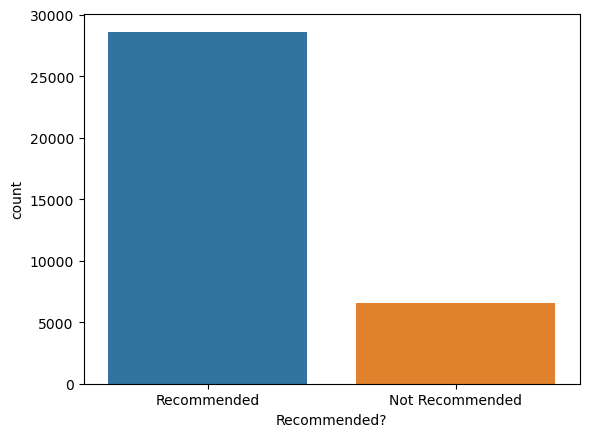

In [12]:
sns.barplot(data=reviews['Recommended?'].value_counts().reset_index(), 
            x='Recommended?',
            y='count');

- Most people recommend playing DS2

Years captured in the webscraped reviews:

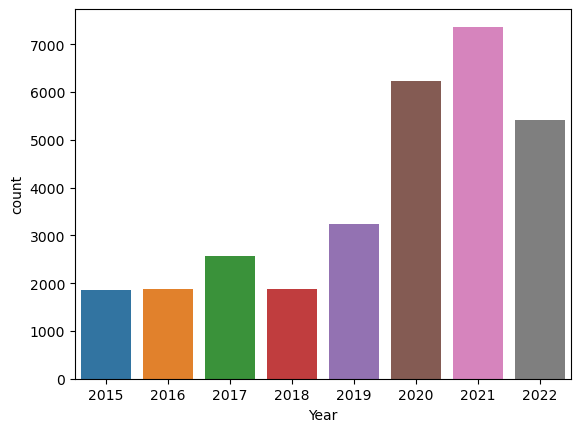

In [13]:
yr_dist = reviews.groupby('Year')['Recommended?'].count().reset_index()
yr_dist.rename(columns={'Recommended?':'count'}, inplace=True)

sns.barplot(data=yr_dist, 
            x='Year',
            y='count');

- Most reviews are fairly recent
    - Game released    : March 2014
    - Remaster released: April 2015 (focus of this project)

Proportions of those who don't and do recommend DS2 in each of the years:

c:\Users\bdion\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


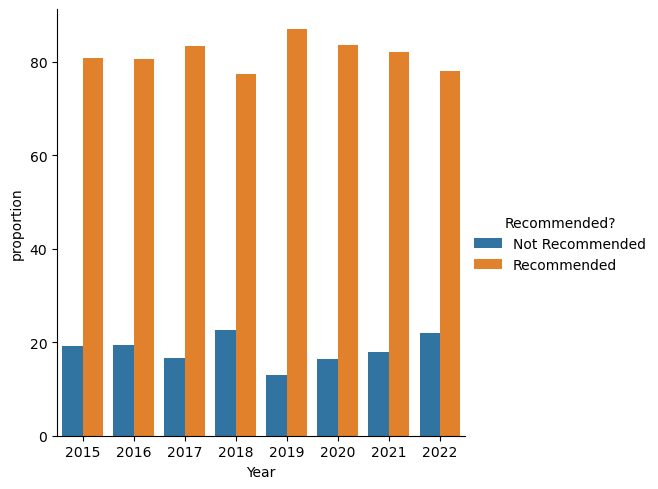

In [14]:
yr_plt = reviews.groupby(['Year', 'Recommended?']).count().reset_index()
yr_plt.rename(columns={'Review':'proportion'}, inplace=True)
yr_plt['proportion'] = 100 * (yr_plt['proportion'] / yr_plt.groupby(['Year'])['proportion'].transform('sum'))

sns.catplot(data=yr_plt,
            kind='bar',
            x='Year',
            y='proportion',
            hue='Recommended?'
            );

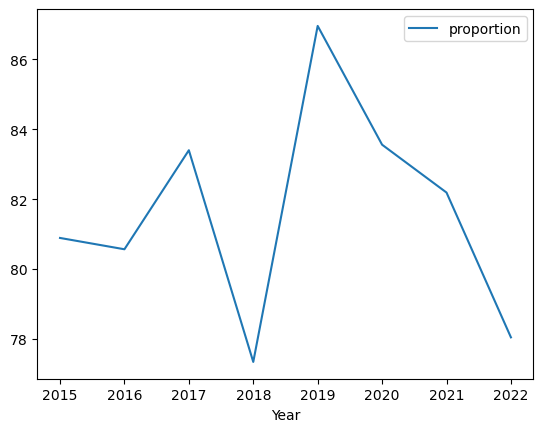

In [15]:
yr_plt[yr_plt['Recommended?'] == 'Recommended'].plot(kind='line',
                                                     x='Year',
                                                     y='proportion');

- Prior to contrary belief, the game was initially praised more than disliked during initial release

## Sentiment Analysis:
- Seeing why people were positive or negative about the game
    - Comments on story, gameplay, etc

For sake of analysis specifically on the actual reviews, drop any rows that have no reviews:

In [16]:
reviews = reviews.dropna(subset=['Review'])
reviews.shape

(35082, 3)

Top 10 Most Common Words in the Reviews:

In [17]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [18]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=4000,
                        tokenizer=word_tokenize,
                        stop_words=stopwords.words("english"))

In [19]:
review_txt = reviews.Review.values.flatten()

In [20]:
tfidf_array = tfidf.fit_transform(review_txt).toarray()
tfidf_df = pd.DataFrame(tfidf_array)
tfidf_df.columns = tfidf.get_feature_names_out()
tfidf_df.head()

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


,aaa,aava,abandoned,abilities,ability,able,absolute,absolutely,absurd,abundance,...,youtube,yup,z,zallen,zelda,zero,zombie,zombies,zone,zones
0,0.0,0.052909,0.0,0.0,0.0,0.033326,0.0,0.032633,0.0,0.0,...,0.0,0.0,0.0,0.0,0.052065,0.0,0.0,0.0,0.114876,0.072168
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [21]:
most_unique = tfidf_df.idxmax(axis=1)
top_10 = most_unique.value_counts()[:10]
top_10

aaa      1545
good      970
best      445
yes       352
dark      285
great     223
nice      221
get       208
bad       196
fun       189
Name: count, dtype: int64

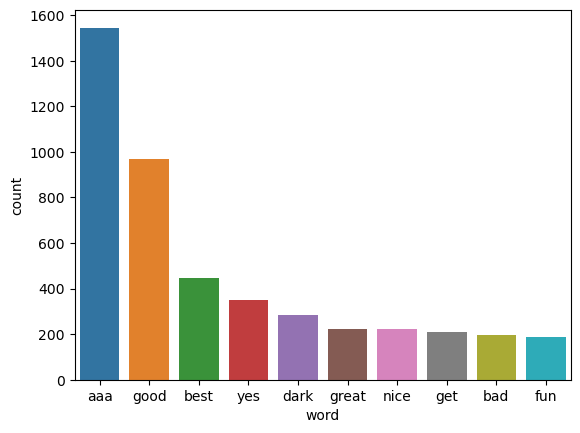

In [22]:
top_10 = top_10.reset_index()
top_10.rename(columns={'index':'word'}, inplace=True)
sns.barplot(data=top_10,
            x='word',
            y='count');

- Most popular word w/ semantic meaning: Triple A 
    - def: an informal classification used to classify video games produced and distributed by a mid-sized or major publisher

Other popular words:

In [23]:
from wordcloud import WordCloud

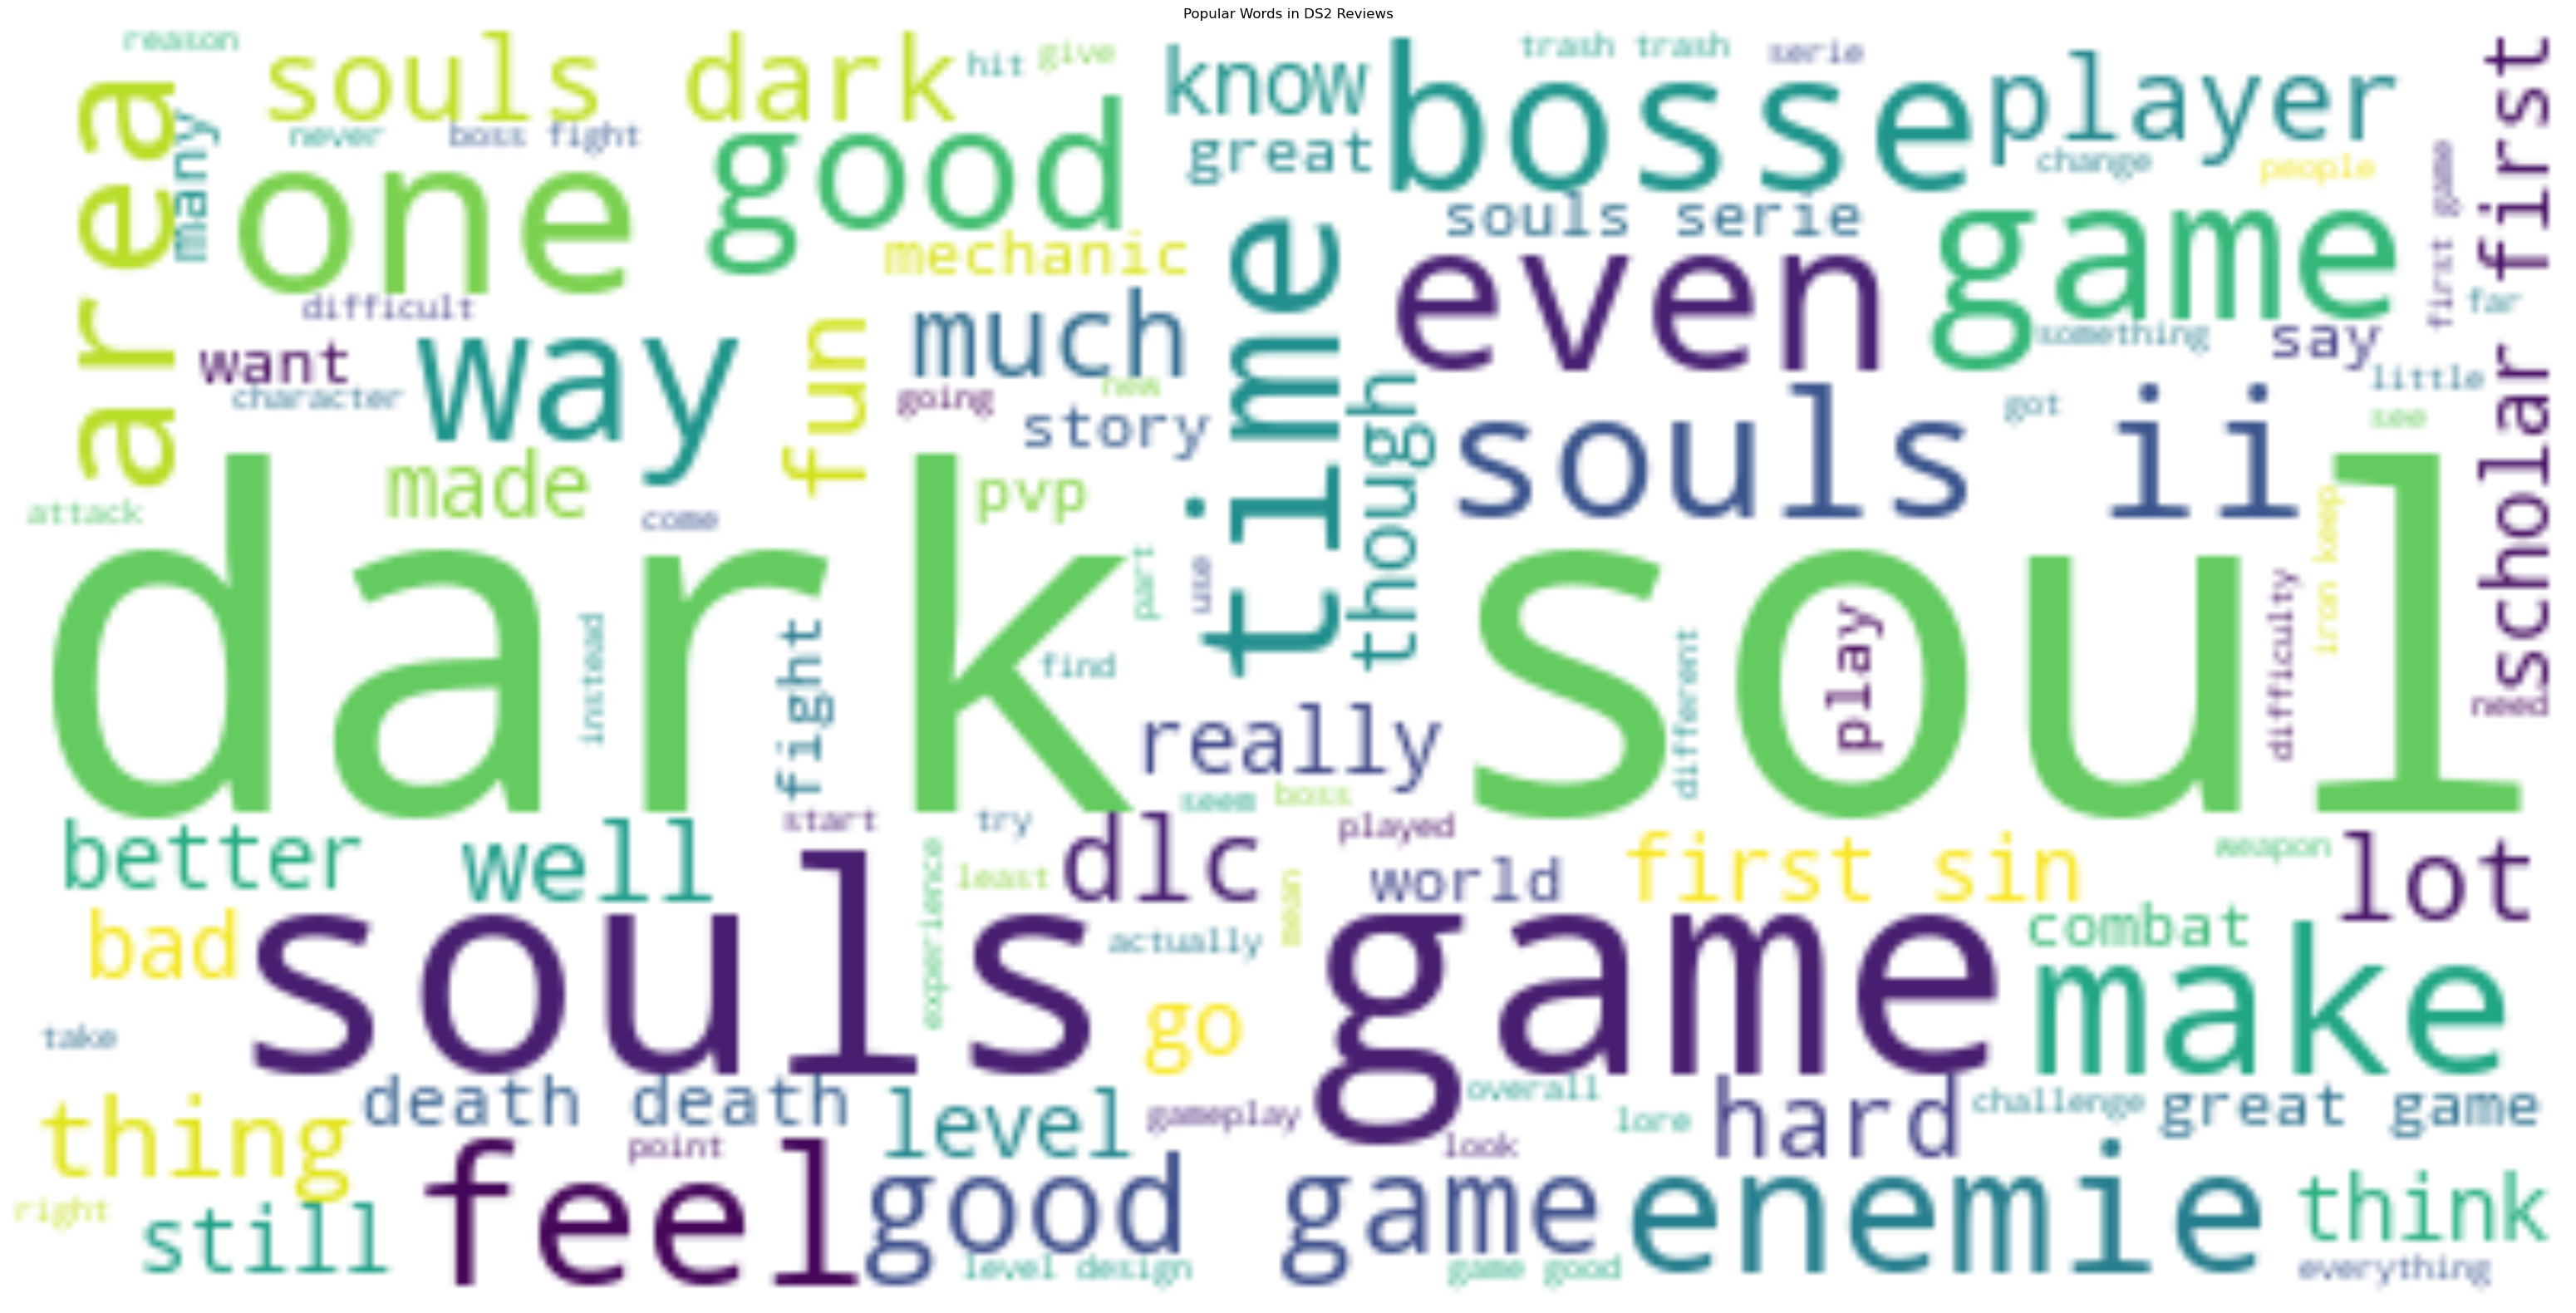

In [24]:
pop_wrds = " ".join( review for review in reviews.Review)
wordcloud = WordCloud(max_font_size=150, max_words=100, background_color="white").generate( pop_wrds )
plt.figure(figsize=(40, 20))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off")
plt.title('Popular Words in DS2 Reviews')
plt.show()

- Most common word among the reviews isn't very informative - including some of the other popular words
    - Looking at subsets of the reviews could be useful

### Topic Modeling:
- Exploring certain aspects on why people like the game
    - Also get critiques of the game in positive reviews (if any but there sure is considering DS2's reputation in the community)

- Exploring why people don't like the game:
    - Also get positive aspects within this subset of the reviews
    
- Algorithms I can use to perform topic modeling:
    1. Latent Dirichlet Allocation (LDA) 
    2. Non-negative Matrix Factorization (NMF)

Splitting the reviews by how many do and don't recommend buying the game:

In [25]:
pos_reviews = reviews[reviews['Recommended?'] == 'Recommended']
neg_reviews = reviews[reviews['Recommended?'] == 'Not Recommended']

In [26]:
pos_reviews.shape, neg_reviews.shape

((28521, 3), (6561, 3))

In [27]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx + 1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx + 1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

LDA: Probabilistic graphical modeling (uses the CountVectorizer as input)

In [28]:
from sklearn.decomposition import LatentDirichletAllocation

In [29]:
count_vector = CountVectorizer()

tf = count_vector.fit_transform(reviews.Review).toarray()
tf_feat_names = count_vector.get_feature_names_out()

pos_tf = count_vector.fit_transform(pos_reviews.Review).toarray()
pos_tf_feat_names = count_vector.get_feature_names_out()

neg_tf = count_vector.fit_transform(neg_reviews.Review).toarray()
neg_tf_feat_names = count_vector.get_feature_names_out()

In [30]:
lda = LatentDirichletAllocation(n_components=5, random_state=42069)
lda.fit(tf)

LatentDirichletAllocation(n_components=5, random_state=42069)

In [ ]:
pos_lda = LatentDirichletAllocation(n_components=5, random_state=42069)
pos_lda.fit(pos_tf)

In [ ]:
neg_lda = LatentDirichletAllocation(n_components=5, random_state=42069)
neg_lda.fit(neg_tf)

In [31]:
no_top_words = 10
display_topics(lda, tf_feat_names, no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,game,1665.2,game,2877.1,game,9981.5,souls,41675.2,death,1597.0
1,good,1356.0,enemies,2578.7,good,3598.8,game,30799.7,trash,1357.9
2,get,1030.3,boss,2251.6,play,1384.1,dark,29877.4,rolin,726.2
3,servers,638.1,souls,2083.4,fun,1137.7,like,7413.7,died,619.0
4,controller,637.5,get,1789.3,best,1007.6,first,6698.5,de,424.2
5,pc,578.8,like,1699.5,like,1000.9,games,5728.7,que,293.2
6,play,573.4,time,1329.7,great,984.4,one,5516.0,underrated,214.3
7,nice,522.7,even,1270.1,bad,966.3,still,5207.9,souls,199.2
8,keyboard,522.2,keep,1259.5,love,936.5,series,4704.6,ring,184.0
9,mouse,501.2,bosses,1248.9,ever,915.5,good,4659.8,elden,182.8


NMF: Uses linear algebra (uses the TF-IDF vectorizer as input) 

In [32]:
from sklearn.decomposition import NMF

In [33]:
nmf = NMF(n_components=5, random_state=42069)
nmf.fit(tfidf_array)

NMF(n_components=5, random_state=42069)

In [34]:
display_topics(nmf, tfidf.get_feature_names_out(), no_top_words)

,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,dark,4.8,good,5.1,game,4.4,best,4.5,like,1.3
1,souls,4.8,get,0.6,great,1.0,souls,0.8,fun,1.2
2,better,0.6,pretty,0.2,hate,0.5,ever,0.6,one,1.1
3,ii,0.3,still,0.1,love,0.3,series,0.4,games,0.9
4,still,0.3,game,0.1,worst,0.2,one,0.4,first,0.9
5,worst,0.3,got,0.0,bad,0.2,pvp,0.2,play,0.9
6,like,0.2,really,0.0,sucks,0.2,games,0.2,get,0.8
7,favorite,0.2,yeah,0.0,nice,0.2,game,0.1,still,0.8
8,play,0.1,actually,0.0,amazing,0.1,played,0.1,really,0.7
9,games,0.1,yes,0.0,souls,0.1,made,0.1,time,0.7


## Conclusion: